<a href="https://colab.research.google.com/github/AmKhG/learning_rate_finder_tf2/blob/master/learning_rate_finder_tf2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding a good learning rate introduced by the paper: "Cyclical Learning Rates for Training Neural Networks"

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import datasets
import numpy as np

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
print('Train data: ', x_train.shape, y_train.shape)
print('Test data', x_test.shape, y_test.shape)

Train data:  (60000, 28, 28) (60000,)
Test data (10000, 28, 28) (10000,)


### Model

In [ ]:
from tensorflow.keras import layers
def get_model():
  model = tf.keras.models.Sequential([
    layers.Flatten(input_shape=(28,28)),
    layers.Dense(units=28*28, activation='relu'),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=10, activation='softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-08), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  print(model.summary())
  return model

In [ ]:
model = get_model()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_39 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_40 (Dense)             (None, 10)                650       
Total params: 666,330
Trainable params: 666,330
Non-trainable params: 0
_________________________________________________________________
None


### Learning rate finder

In [ ]:
# need to know the number of batch per epoch
batch_size=32
num_batch_per_epoch=x_train.shape[0] / batch_size
print(num_batch_per_epoch)

1875.0


In [ ]:
from tensorflow.keras import callbacks
import tensorflow.keras.backend as backend
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# credit goes to here:
# https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html#how-do-you-find-a-good-learning-rate

class find_lr(callbacks.Callback):

  def __init__(self, init_value=5e-04, 
               final_value=10.0, 
               beta=0.98, 
               # use the value above here
               num_batch_per_epoch=1875.0):
    #b/c we call on_batch_end and not on_batch_begin(b/c we won't have loss)
    self.batch_num = 1
    self.avg_loss = 0.0
    self.beta = beta
    self.best_loss = 0.0
    self.losses = []
    self.lr_val = init_value
    self.final_lr_val = final_value
    self.num_batch_per_epoch = num_batch_per_epoch
    self.mult = (self.final_lr_val / self.lr_val) ** (1.0 / self.num_batch_per_epoch)
    self.log_lrs = []
    self.lrs = []

  def on_batch_end(self, batch, logs={}):
    # tensorflow will train till end of epoch, but we don't need to update here
    if self.model.stop_training:
      return

    self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * logs['loss']
    smoothed_loss = self.avg_loss / (1.0 - self.beta ** self.batch_num)
    if self.batch_num > 1 and smoothed_loss > 4 * self.best_loss:
      print('\nLoss is too big now, cancelling training.')
      self.model.stop_training = True
      return

    if smoothed_loss < self.best_loss or self.batch_num == 1:
      self.best_loss = smoothed_loss

    self.losses.append(smoothed_loss)
    self.log_lrs.append(np.math.log10(self.lr_val))

    # new lr
    self.lr_val *= self.mult
    backend.set_value(self.model.optimizer.learning_rate, self.lr_val)
    print('\nbatch_num: {}, lr: {}, loss: {:3.2f}, smoothed_loss: {:3.2f}, best_loss: {:3.2f}'.format(self.batch_num, 
                                                                                       self.model.optimizer.lr.numpy(), 
                                                                                       logs['loss'],
                                                                                       smoothed_loss,
                                                                                       self.best_loss))

    self.batch_num += 1

  def plot_lr(self):
    """
    Plots the learning rate
    """
    plt.plot(self.log_lrs[10:-5], self.losses[10:-5])
    plt.ylabel('loss')
    plt.xlabel('learning_rate(log scale)')
    plt.title('Loss vs LR')

lr_finder = find_lr()

In [ ]:
model = get_model()
history = model.fit(x_train, y_train,
                    epochs=1,
                    batch_size=batch_size,
                    validation_data=(x_test, y_test),
                    callbacks=[lr_finder])

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 784)               615440    
_________________________________________________________________
dense_42 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_43 (Dense)             (None, 10)                650       
Total params: 666,330
Trainable params: 666,330
Non-trainable params: 0
_________________________________________________________________
None

batch_num: 1, lr: 0.0005026478902436793, loss: 123.23, smoothed_loss: 123.23, best_loss: 123.23
   1/1875 [..............................] - ETA: 0s - loss: 123.2293 - accuracy: 0.0312
batch_num: 2, lr: 0.000505309842992574, loss: 125.76, 

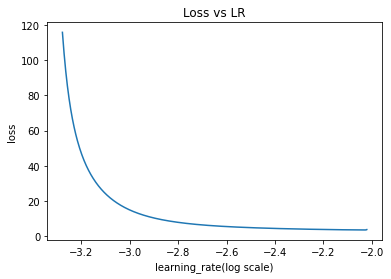

In [ ]:
lr_finder.plot_lr()
